# Pre-process of tracks from Free Music Archive 

In [1]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display


from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch

import random
import utils
import utils_mgr

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Load metadata and features.
tracks = utils.load('Data/fma_metadata/tracks.csv')

#Check tracks format
tracks.shape 

(106574, 52)

# Audio

Audio signals are composed by a one-dimensional array that represents the amplitude of the audio signal over time, x in our definition. sr is instead the sampling rate providing the context for how these samples are distributed in time. The librosa.load function returns both the audio signal and its associated sampling rate.

In [7]:
#Function getAudio to extract tracks from .mp3 file
x_ex = utils_mgr.getAudio(2)

#Print some track features
print(x_ex[1])
duration_seconds = x_ex[0].shape[-1] / x_ex[1]
print(f'Duration: {duration_seconds:.2f}s, {x_ex[0].size} samples')

# Play a segment of the audio (Clip that will be used as Cnn input)
start, end = 15, 18
ipd.Audio(data=x_ex[0][start * x_ex[1] : end * x_ex[1]], rate=x_ex[1])

22050
Duration: 29.98s, 660984 samples


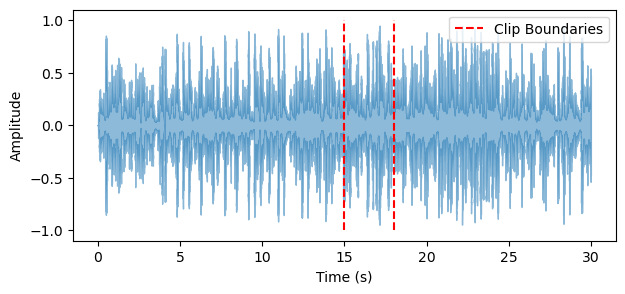

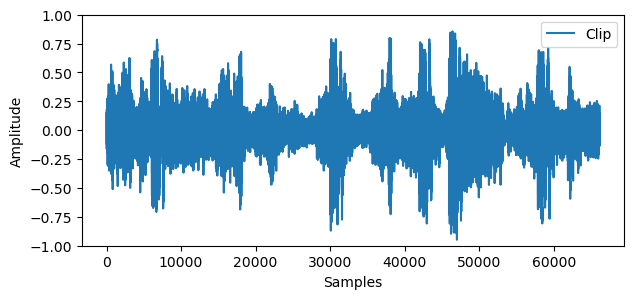

In [11]:
# Plot the entire waveform with vertical lines
plt.figure(figsize=(7, 3))
librosa.display.waveshow(x_ex[0], alpha=0.5)
plt.vlines([start, end], -1, 1, color='r', linestyle='--', label='Clip Boundaries')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

# Create another plot for a segment of the audio signal
plt.figure(figsize=(7, 3))
plt.plot(x_ex[0][start * x_ex[1] : end * x_ex[1]], label='Clip') 
plt.ylim((-1, 1))
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.show()

## Compute stft spectrogram

STFT spectrogram provides a time-frequency representation of a signal, allowing you to observe how the frequency content changes over time. It is widely used in various applications such as audio analysis, speech processing, and music signal processing.

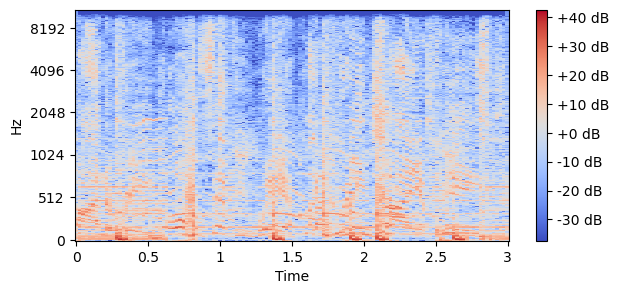

In [12]:
# Compute the short-time Fourier transform (stft)
stft_ex = np.abs(librosa.stft(x_ex[0][start * x_ex[1] : end * x_ex[1]], n_fft=1024, hop_length=512))

# Convert the power spectrogram to decibels
log_stft_ex = librosa.amplitude_to_db(stft_ex)

# Plot the log mel spectrogram for visualization purpose 
plt.figure(figsize=(7, 3))
librosa.display.specshow(log_stft_ex, sr=x_ex[1], hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Creation of training, test and validation sets

In [ ]:
#Select the desired subset among the entire dataset
sub = 'small'
raw_subset = tracks[tracks['set', 'subset'] <= sub]

In [13]:
#Location of labels of interest for classification
labels = raw_subset['track']['genre_top']
labels = np.array(labels)

['Hip-Hop' 'Hip-Hop' 'Pop' ... 'Pop' 'Pop' 'Hip-Hop']


array(['Hip-Hop', 'Hip-Hop', 'Pop', 'Folk', 'Folk', 'Experimental',
       'Rock', 'Folk', 'Folk', 'Folk'], dtype=object)

In [14]:
#get track feature for the splitting in trainging, test and validation sets
train_meta = raw_subset[raw_subset['set', 'split'] == 'training']
val_meta = raw_subset[raw_subset['set', 'split'] == 'validation']
test_meta = raw_subset[raw_subset['set', 'split'] == 'test']
test_meta.shape


(800, 52)

In [15]:
#Creation of clean subset for the generation of training, test and validation sets

subset= utils_mgr.create_subset(raw_subset)

In [41]:
subset[:10]


,index,genre_top,split,labels
0,2,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
1,5,Hip-Hop,training,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,10,Pop,training,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,140,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,141,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,148,Experimental,validation,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
6,182,Rock,test,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
7,190,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
8,193,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,194,Folk,training,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [99]:
#Creation of Audio datasets arrays

test = utils_mgr.splitAudio(subset, 'test')

In [102]:
training = utils_mgr.splitAudio(subset, 'training')
validation = utils_mgr.splitAudio(subset, 'validation')

problems with song:  98565
problems with song:  98567
problems with song:  98569
problems with song:  99134
problems with song:  108925
problems with song:  133297


In [105]:
#Visualize dataset array
training[:10]

array([[array([1.4901161e-08, 2.6077032e-08, 3.7252903e-09, ..., 1.6384501e-02,
               9.9678345e-02, 1.1190173e-01], dtype=float32)                   ,
        array([1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)],
       [array([-1.4901161e-08,  0.0000000e+00, -2.9802322e-08, ...,
                6.5507650e-01,  5.7660806e-01,  1.9273445e-01], dtype=float32),
        array([0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)],
       [array([ 1.4901161e-08, -1.4901161e-08, -7.4505806e-09, ...,
                1.8215898e-01,  1.8937059e-01,  1.1931620e-01], dtype=float32),
        array([0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)],
       [array([ 0.0000000e+00,  1.8626451e-09,  9.3132257e-09, ...,
               -2.6587474e-01, -2.9781884e-01, -2.0770611e-01], dtype=float32),
        array([0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)],
       [array([-1.8626451e-08, -3.2596290e-08, -2.0489097e-08, ...,
               -5.1224840e-01, -5.4195893e-01, -3.4575590e-01], dty

In [108]:
utils_mgr.saveheavy(test, 'test', 2)
utils_mgr.saveheavy(validation, 'validation', 2)
utils_mgr.saveheavy(training, 'training', 16)